In [1]:
import torch
from torch import nn, optim
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
gpu = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu = True
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True, num_workers=4)

In [4]:
from matplotlib import pyplot as plt

torch.Size([512, 1, 28, 28])
torch.Size([512])
tensor(5)


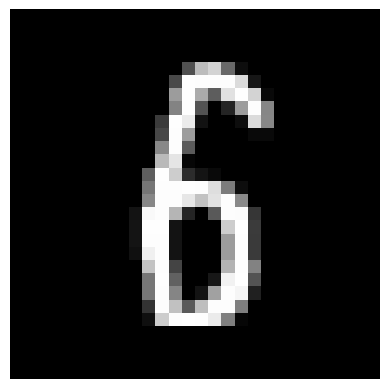

In [5]:
for batch in train_dataloader:
    img, label = batch
    print(img.shape)
    print(label.shape)
    print(label[0])
    plt.imshow(img[0, 0, :, :].numpy(), cmap='gray')
    plt.axis('off')
    plt.show()
    break;

In [6]:
class VAEEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, hidden_size2=256, **kwargs):
        super(VAEEncoder, self).__init__(**kwargs)
        self.linear = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, hidden_size2)
        self.relu2 = nn.ReLU()
        self.mu = nn.Linear(hidden_size2, latent_size)
        self.sigma = nn.Linear(hidden_size2, latent_size)
    
    def forward(self, X):
        X = self.linear(X)
        X = self.relu(X)
        X = self.linear2(X)
        X = self.relu2(X)
        return self.mu(X), self.sigma(X)

In [7]:
class VAEDecoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size, hidden_size2=256, **kwargs):
        super(VAEDecoder, self).__init__(**kwargs)
        self.linear1 = nn.Linear(latent_size, hidden_size2)
        self.a1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size2, hidden_size)
        self.a2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_size, output_size)
        self.a3 = nn.Sigmoid()
    
    def forward(self, X):
        X = self.linear1(X)
        X = self.a1(X)
        X = self.linear2(X)
        X = self.a2(X)
        X = self.linear3(X)
        return self.a3(X)

In [8]:
class VAE(nn.Module):
    def __init__(self, input_size, output_size, latent_size, hidden_size, hidden_size2, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = VAEEncoder(input_size, hidden_size, latent_size, hidden_size2)
        self.decoder = VAEDecoder(latent_size, hidden_size, output_size, hidden_size2)
    
    def forward(self, X):
        mu, sigma = self.encoder(X)
        eps = torch.randn_like(mu)
        Z = mu + eps * sigma # 使用平均分布而非正态分布
        return self.decoder(Z), mu, sigma

In [9]:
latent_size, hidden_size, hidden_size2 = 32, 512, 128
input_size = 28 * 28
output_size = input_size

In [10]:
lr = 1e-4
num_epochs = 6000

In [11]:
from matplotlib import pyplot as plt
import numpy as np

In [12]:
net = VAE(input_size, output_size, latent_size, hidden_size, hidden_size2)

In [13]:
def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
net.apply(xavier_init_weights)
optimizer = optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-3)

In [14]:
import os
def load_model():
    if os.path.exists('data/vae_mnist/vae.pth'):
        net.load_state_dict('data/vae_mnist/vae.pth')
        optimizer.load_state_dict('data/vae_mnist/vae_optim.pth')
        print("model loaded")
    else:
        print("no model to load, skip.")
load_model()

no model to load, skip.


In [15]:
from IPython import display
def loss(X_re, X, mu, sigma):
    loss1 = nn.BCELoss()
    kl = -0.5 * torch.sum(1+sigma - torch.exp(sigma) - mu**2)
    return loss1(X_re, X) + kl
def train(net, data_iter, num_epochs, lr, device):
    net.to(device)
    net.train()
    
    loss_history = []
    for epoch in range(num_epochs):
        loss_value = 0
        for (X,Y ) in data_iter:
            optimizer.zero_grad()
            X, Y = X.to(device), Y.to(device)
            X = X.reshape(X.shape[0], X.shape[1], -1)
            X_re, mu, sigma = net(X)
            l = loss(X_re, X, mu, sigma)
            l.sum().backward()
            optimizer.step()
            loss_value += l.item()
        if epoch > 10:
            loss_history.append(loss_value)
            plt.plot(np.arange(len(loss_history)), loss_history)
            plt.xlabel('Iterations')
            plt.ylabel('Loss')
            display.display(plt.gcf())
            display.clear_output(wait=True)
    plt.plot(np.arange(len(loss_history)), loss_history)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    display.display(plt.gcf())
    display.clear_output(wait=True)

KeyboardInterrupt: 

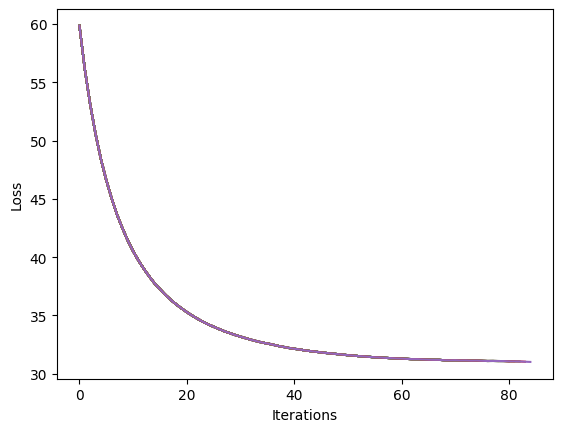

In [16]:
train(net, train_dataloader, num_epochs, lr, device)

In [19]:
def save_model():
    torch.save(net.state_dict(), 'data/vae_mnist/vae.pth')
    torch.save(optimizer.state_dict(), 'data/vae_mnist/vae_optim.pth')
save_model()

In [20]:
def predict(net, latent_size, device):
    net.eval()
    sample = torch.randn(1, latent_size).to(device)
    generate = net.decoder(sample).cpu().detach().numpy().reshape(28, 28)
    plt.imshow(generate, cmap='gray')
    plt.axis('off')
    plt.show()

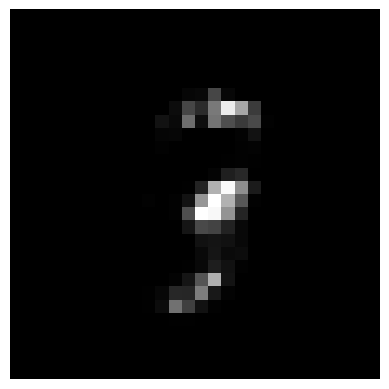

In [34]:
predict(net, latent_size, device)